# Models Pipeline

We want to see how different models affect our dataset.

In [1]:
import numpy as np
from preprocessing import load_dataset, split_dataset, grid_search, feature_interaction_polynomyal_degreee2, corresponding_features_interaction, corresponding_features_custom_interaction
from utilities import plot_grid_results, print_log
import models
import warnings

We define the generic parameters, to be used to split the dataset.

In [2]:
test_size = 0.2         # the ratio of the dataset we want to use as test set
stratify = True         # Whether we want the split to keep the same proportion between classes as the original dataset
k = 5                   # The number of folds for the (stratified) k fold 

warnings.filterwarnings('ignore')  # Warnings in the notebook

First of all, we load the dataset and we split it into training and test set (to be used only in the end).

We also apply different feature transformations to see if they improve our results.

In [3]:
# first, we load the dataset
X, y = load_dataset('./data/data.pkl')
# then, we split it
X_tr, y_tr, X_te, y_te = split_dataset(X, y, test=test_size, stratify=stratify)

# generate the dataset version with polynomyal features of degree 2
X_tr_poly = feature_interaction_polynomyal_degreee2(X_tr)

# generate the dataset version containing corresponding features interaction (the product)
# for example: (interest in music of x) * (interest in music of y)
X_tr_int_only = corresponding_features_interaction(X_tr, drop=True)

# generate the dataset version containing the result of a custom function that
# consider features interaction rewarding shared interests and penalizing unmatched interests
X_tr_custom_int_only = corresponding_features_interaction(corresponding_features_custom_interaction(X_tr), drop=True)

Now, we can start to try the grid search with different models, to see how it behaves.

Notice we want to have high __*recall*__ for class 'MATCH' (that is, we want to detect as many MATCH samples as possible). For this reason, we put recall as main metric for our grid search.

## Gaussian Mixture Modelling

### 1. No interactions, no PCA

In [4]:
# get pipeline 
pipe, grid = models.scaling(models.gmm)
# call grid_search
gmm_performance, gmm_model = grid_search(X_tr, y_tr, pipe, grid, k)

print_log(gmm_performance)

Best model (according to recall): {'model__covariance_type': 'diag', 'model__n_components': 1}
-----------------------------------------
Recall : 0.8970840427178455
Balanced accuracy: 0.5149864287220125
f1: 0.27103423046195474


### 2. Polynomial transformation, over sampling and PCA

In [5]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.gmm)
# call grid_search
gmm_poly_performance, gmm_poly_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(gmm_poly_performance)

Best model (according to recall): {'model__covariance_type': 'diag', 'model__n_components': 1, 'pca__n_components': 25}
-----------------------------------------
Recall : 0.57029011676899
Balanced accuracy: 0.5367633637374543
f1: 0.26565224249434777


### 3. Interactions only, over sampling and PCA

In [6]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.gmm)
# call grid_search
gmm_int_performance, gmm_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(gmm_int_performance)

Best model (according to recall): {'model__covariance_type': 'full', 'model__n_components': 16, 'pca__n_components': 25}
-----------------------------------------
Recall : 0.25947101411890144
Balanced accuracy: 0.4961684680047287
f1: 0.19053847425797538


### 4. Custom interactions only, over sampling

In [7]:
# get pipeline 
pipe, grid = models.over_sampling(models.gmm)
# call grid_search
gmm_cint_performance, gmm_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(gmm_cint_performance)

Best model (according to recall): {'model__covariance_type': 'diag', 'model__n_components': 4}
-----------------------------------------
Recall : 0.6412394022253177
Balanced accuracy: 0.5580310167420751
f1: 0.28451859562701237


## Gradient Boosting Tree

### 1. No interactions, no PCA

In [8]:
# get pipeline 
pipe, grid = models.scaling(models.gradient_boosting)
# call grid_search
gb_performance, gb_model = grid_search(X_tr, y_tr, pipe, grid, k)

print_log(gb_performance)

Best model (according to recall): {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_split': 6}
-----------------------------------------
Recall : 0.15306838106370543
Balanced accuracy: 0.5504789077101417
f1: 0.2117974487313914


### 2. Polynomial transformation, over sampling and PCA

In [9]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.gradient_boosting)
# call grid_search
gb_pt_performance, gb_pt_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(gb_pt_performance)

Best model (according to recall): {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_split': 6, 'pca__n_components': 25}
-----------------------------------------
Recall : 0.3095850379894799
Balanced accuracy: 0.5684742287402103
f1: 0.2741306452264344


### 3. Interactions only, over sampling and PCA

In [10]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.gradient_boosting)
# call grid_search
gb_int_performance, gb_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(gb_int_performance)

Best model (according to recall): {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_samples_split': 6, 'pca__n_components': 66}
-----------------------------------------
Recall : 0.05458796025715955
Balanced accuracy: 0.5040649428461919
f1: 0.0810801738815247


### 4. Custom interactions only, over sampling

In [11]:
# get pipeline 
pipe, grid = models.over_sampling(models.gradient_boosting)
# call grid_search
gb_cint_performance, gb_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(gb_cint_performance)

Best model (according to recall): {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_samples_split': 6}
-----------------------------------------
Recall : 0.13939216832261836
Balanced accuracy: 0.5455236506525061
f1: 0.19899275308114495


## K-Nearest Neighbors

We run a grid search on the kNN model, trying values of k from 1 to 10. Since our data is highly dimensional, we expect such an algorithm to perform bad.

### 1. No interactions, no PCA

In [12]:
# get pipeline 
pipe, grid = models.scaling(models.knn)
# call grid_search
knn_performance, knn_model = grid_search(X_tr, y_tr, pipe, grid, k)

print_log(knn_performance)

Best model (according to recall): {'model__n_neighbors': 1, 'model__weights': 'uniform'}
-----------------------------------------
Recall : 0.22121566335476328
Balanced accuracy: 0.5368385842256359
f1: 0.21913922867942187


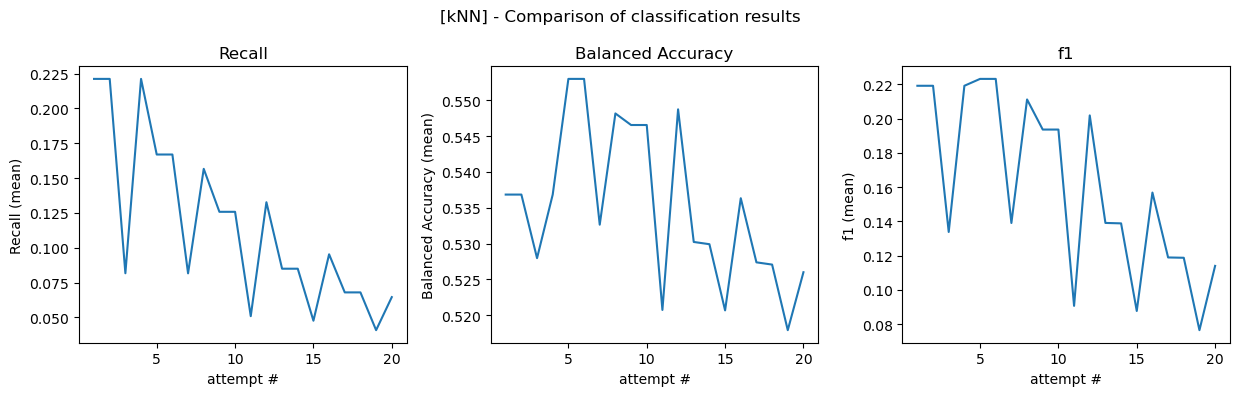

In [13]:
# Plot recall, balanced accuracy and f1 metric for every k in the range
plot_grid_results(knn_performance, 'kNN')

### 2. Polynomial transformation, over sampling and PCA

In [14]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.knn)
# call grid_search
knn_pt_performance, knn_pt_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(knn_pt_performance)

Best model (according to recall): {'model__n_neighbors': 9, 'model__weights': 'uniform', 'pca__n_components': 66}
-----------------------------------------
Recall : 0.5953828170660433
Balanced accuracy: 0.6011741868694108
f1: 0.3207046546907327


### 3. Interactions only, over sampling and PCA

In [15]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.knn)
# call grid_search
knn_int_performance, knn_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(knn_int_performance)

Best model (according to recall): {'model__n_neighbors': 1, 'model__weights': 'distance', 'pca__n_components': 66}
-----------------------------------------
Recall : 0.2075394506136762
Balanced accuracy: 0.5265492446380816
f1: 0.20352890835409904


### 4. Custom interactions only, over sampling

In [16]:
# get pipeline 
pipe, grid = models.over_sampling(models.knn)
# call grid_search
knn_cint_performance, knn_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(knn_cint_performance)

Best model (according to recall): {'model__n_neighbors': 9, 'model__weights': 'uniform'}
-----------------------------------------
Recall : 0.6632963179427236
Balanced accuracy: 0.5249941103524465
f1: 0.2659727235347475


### 5. Custom interactions only, over sampling, PCA

In [17]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.knn)
# call grid_search
knn_cint_pca_performance, knn_cint_pca_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(knn_cint_pca_performance)

Best model (according to recall): {'model__n_neighbors': 9, 'model__weights': 'distance', 'pca__n_components': 66}
-----------------------------------------
Recall : 0.6394506136762128
Balanced accuracy: 0.5777003073309988
f1: 0.3010686286346323


## Logistic Regression

Normal Logistic Regression does not converge. We try some strategies to reduce the dimensionality of our data.

### 1. Polynomial transformation, scaling

In [18]:
# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
lr_pt_performance, lr_pt_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(lr_pt_performance)

Best model (according to recall): {'model__C': 10000}
-----------------------------------------
Recall : 0.3573933372296902
Balanced accuracy: 0.6096444022951748
f1: 0.33483231530533963


### 2. Interactions only, scaling

In [19]:
# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
lr_int_performance, lr_int_model  = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(lr_int_performance)

Best model (according to recall): {'model__C': 10}
-----------------------------------------
Recall : 0.48971361776738753
Balanced accuracy: 0.5511845626740369
f1: 0.2738810777032711


### 3. Interactions only, over sampling and PCA

In [20]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[20, 30, 66], model_f=models.logistic_regression)
# call grid_search
lr_int_pca_performance, lr_int_pca_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(lr_int_pca_performance)

Best model (according to recall): {'model__C': 10000, 'pca__n_components': 66}
-----------------------------------------
Recall : 0.06814728229105785
Balanced accuracy: 0.5099041649916676
f1: 0.10165470476540601


### 4. Custom interactions and scaling

In [21]:
# get pipeline 
pipe, grid = models.scaling(models.logistic_regression)
# call grid_search
lr_cint_performance, lr_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(lr_cint_performance)

Best model (according to recall): {'model__C': 10}
-----------------------------------------
Recall : 0.4624780829924021
Balanced accuracy: 0.5520124883919642
f1: 0.2716746184828013


## Random Forest

### 1. Polynomial transformation, over sampling and scaling

In [22]:
# get pipeline 
pipe, grid = models.over_sampling(models.scaling, model_f = models.random_forest)
# call grid_search
rf_performance, rf_model = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(rf_performance)

Best model (according to recall): {'model__criterion': 'gini', 'model__min_samples_split': 2, 'model__n_estimators': 200}
-----------------------------------------
Recall : 0.14611338398597312
Balanced accuracy: 0.5592468302000408
f1: 0.22317282297575497


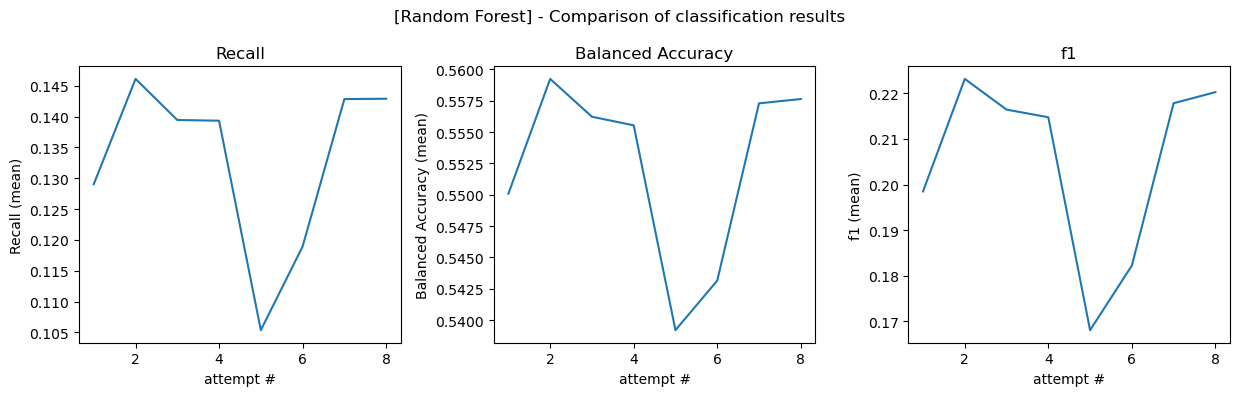

In [23]:
plot_grid_results(rf_performance, 'Random Forest')

### 2. Interactions over sampling and scaling

In [24]:
# get pipeline 
pipe, grid = models.over_sampling(models.scaling, model_f = models.random_forest)
# call grid_search
rf_int_performance, rf_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(rf_performance)

Best model (according to recall): {'model__criterion': 'gini', 'model__min_samples_split': 2, 'model__n_estimators': 200}
-----------------------------------------
Recall : 0.14611338398597312
Balanced accuracy: 0.5592468302000408
f1: 0.22317282297575497


### 3. Custom interactions and over sampling

In [25]:
# get pipeline 
pipe, grid = models.over_sampling(models.random_forest)
# call grid_search
rf_cint_performance, rf_cint_model  = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(rf_cint_performance)

Best model (according to recall): {'model__criterion': 'entropy', 'model__min_samples_split': 2, 'model__n_estimators': 100}
-----------------------------------------
Recall : 0.05791934541203975
Balanced accuracy: 0.5154573758270151
f1: 0.09395959595959595


## Support Vector Machines

### 1. Polynomial transformation, scaling

In [26]:
# get pipeline 
pipe, grid = models.scaling(models.svm)
# call grid_search
svm_performance, svm_model  = grid_search(X_tr_poly, y_tr, pipe, grid, k)

print_log(svm_performance)

Best model (according to recall): {'model__kernel': 'rbf'}
-----------------------------------------
Recall : 0.3982466393921683
Balanced accuracy: 0.6153089232922279
f1: 0.3453200079036801


### 2. Interactions only, over sampling and PCA

In [27]:
# get pipeline 
pipe, grid = models.over_sampling(models.pca, n_components=[25, 66], model_f = models.svm)
# call grid_search
svm_int_performance, svm_int_model = grid_search(X_tr_int_only, y_tr, pipe, grid, k)

print_log(svm_int_performance)

Best model (according to recall): {'model__kernel': 'linear', 'pca__n_components': 25}
-----------------------------------------
Recall : 0.03395675043834016
Balanced accuracy: 0.5041069807277365
f1: 0.05628174603174604


### 3. Custom interactions and over sampling

In [28]:
# get pipeline 
pipe, grid = models.over_sampling(models.svm)
# call grid_search
svm_cint_performance, svm_cint_model = grid_search(X_tr_custom_int_only, y_tr, pipe, grid, k)

print_log(svm_cint_performance)

Best model (according to recall): {'model__kernel': 'linear'}
-----------------------------------------
Recall : 0.45248392752776156
Balanced accuracy: 0.5102880196381735
f1: 0.23796820839420038


## Best model selection and test
The model having the best performances in term of __recall__ is GMM without features interaction and PCA, the obtained result is not satisfactory.
Now we check its performances against the test set.

In [39]:
test_recall = gmm_model.score(X_te, y_te)
test_accuracy = np.count_nonzero(gmm_model.best_estimator_.predict(X_te) == y_te) / len(y_te)

print("Recall on test set: ", test_recall)
print("Accuracy on test set: ", test_accuracy)

Recall on test set:  0.8918918918918919
Accuracy on test set:  0.2902542372881356
